**Purpose: Being a homeowner is great in many different areas, but having to take care of your grass is not one of them.**

While my grass is not the worst of the block, I've decided to step it up to amateur status. Grass needs 1-2 inches of water per week, and I've just been guessing in the previous two years. Now, I've finally procured some gauges and found out I've been underwatering by a fair amount!

I need to know how much free stuff nature is providing per week and what I need to contribute via a high water bill.

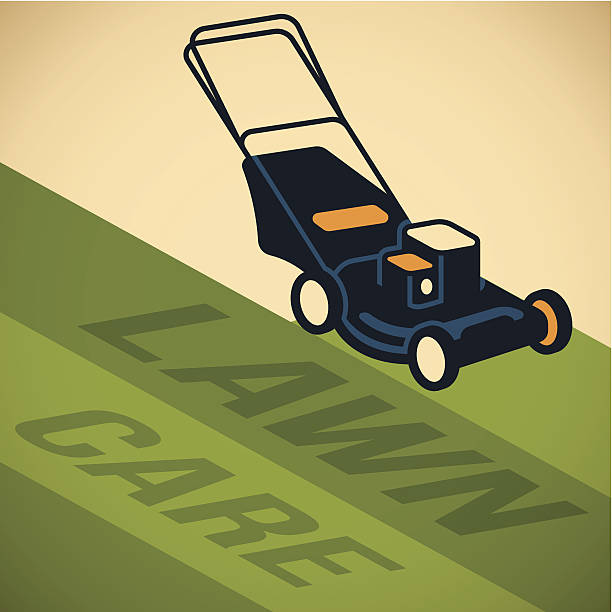

In [17]:
import requests
import datetime
from datetime import timedelta
import json
import os
import math
import time
import pandas as pd
import sys
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors
import psycopg2.extras as extras
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

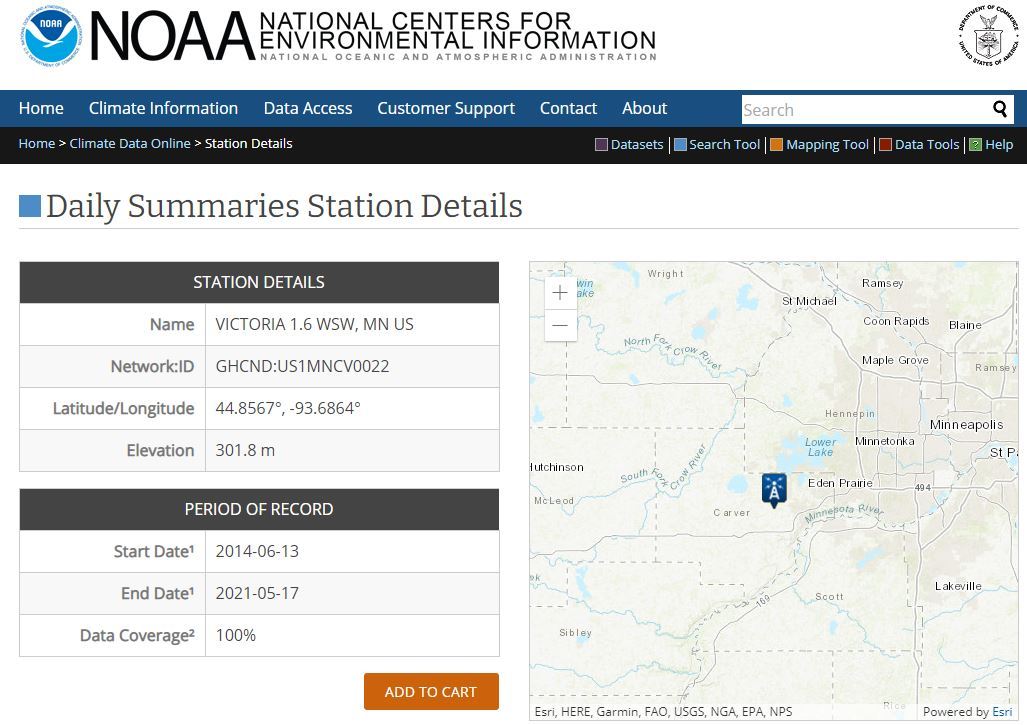

In [18]:
#api information
Token = 'XXXX'
station_id = 'US1MNCV0022'
start_date = '2021-05-01'
end_date = pd.to_datetime('today').date()
data_type_id = 'PRCP'

In [19]:
#api information
base_url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:'

url = base_url + station_id + '&startdate=' + str(start_date) + '&enddate=' + str(end_date) + '&datatypeid=' + str(data_type_id) + '&units=standard&limit=1000&includemetadata=false'

In [20]:
#request & load data from api
r = requests.get(url, headers={'token':Token})
d = json.loads(r.text)

In [21]:
#convert records from nested json to flat pandas dataframe. 
api_records = json.loads(r.text)['results']
df = pd.pivot_table(pd.DataFrame(api_records), index=['date'], columns='datatype', values='value')
reshaped_df = df.rename_axis(None, axis=1).reset_index()

#clean up the date & PRCP column
reshaped_df.date = reshaped_df.date.str.slice(0, 10)
reshaped_df.columns= reshaped_df.columns.str.lower()

In [22]:
reshaped_df['date'] = pd.to_datetime(reshaped_df['date'], format='%Y-%m-%d')

In [23]:
reshaped_df['week_number_of_year'] = reshaped_df['date'].dt.strftime('%U')

In [24]:
reshaped_df['prcp_sum'] = reshaped_df.groupby('week_number_of_year')['prcp'].transform('sum')

In [25]:
reshaped_df['prcp_rolling_seven'] = reshaped_df['prcp'].rolling(7).sum()
reshaped_df['prcp_rolling_seven'] = reshaped_df['prcp_rolling_seven'].fillna(0)

In [26]:
reshaped_df

,date,prcp,week_number_of_year,prcp_sum,prcp_rolling_seven
0,2021-05-01,0.00,17,0.00,0.00
1,2021-05-02,0.00,18,0.08,0.00
2,2021-05-03,0.00,18,0.08,0.00
3,2021-05-04,0.00,18,0.08,0.00
4,2021-05-05,0.00,18,0.08,0.00
5,2021-05-06,0.08,18,0.08,0.00
6,2021-05-07,0.00,18,0.08,0.08
7,2021-05-08,0.00,18,0.08,0.08
8,2021-05-09,0.00,19,0.02,0.08
9,2021-05-10,0.00,19,0.02,0.08


In [27]:
# Note: please change your database, username & password as per your own values

conn_params_dic = {
    "host"      : "XXXX.rds.amazonaws.com",
    "database"  : "XXXX",
    "user"      : "XXXX",
    "password"  : "XXXX"
}

In [28]:
# Define a function that handles and parses psycopg2 exceptions
def show_psycopg2_exception(err):
    # get details about the exception
    err_type, err_obj, traceback = sys.exc_info()    
    # get the line number when exception occured
    line_n = traceback.tb_lineno    
    # print the connect() error
    print ("\npsycopg2 ERROR:", err, "on line number:", line_n)
    print ("psycopg2 traceback:", traceback, "-- type:", err_type) 
    # psycopg2 extensions.Diagnostics object attribute
    print ("\nextensions.Diagnostics:", err.diag)    
    # print the pgcode and pgerror exceptions
    print ("pgerror:", err.pgerror)
    print ("pgcode:", err.pgcode, "\n")
    
# Define a connect function for PostgreSQL database server
def connect(conn_params_dic):
    conn = None
    try:
        print('Connecting to the PostgreSQL...........')
        conn = psycopg2.connect(**conn_params_dic)
        print("Connection successfully..................")
        
    except OperationalError as err:
        # passing exception to function
        show_psycopg2_exception(err)        
        # set the connection to 'None' in case of error
        conn = None
    return conn

# Define function using cursor.executemany() to insert the dataframe
def execute_many(conn, datafrm, table):
    
    # Creating a list of tupples from the dataframe values
    tpls = [tuple(x) for x in datafrm.to_numpy()]
    
    # dataframe columns with Comma-separated
    cols = ','.join(list(datafrm.columns))
    
    # SQL query to execute
    sql = "INSERT INTO %s(%s) VALUES(%%s,%%s,%%s,%%s,%%s)" % (table, cols)
    cursor = conn.cursor()
    try:
        cursor.executemany(sql, tpls)
        conn.commit()
        print("Data inserted using execute_many() successfully...")
    except (Exception, psycopg2.DatabaseError) as err:
        # pass exception to function
        show_psycopg2_exception(err)
        cursor.close()

In [29]:
# Connect to the database
conn = connect(conn_params_dic)
conn.autocommit = True
# Run the execute_many method
execute_many(conn, reshaped_df, 'rainfall')
# Close the connection
conn.close()

Connecting to the PostgreSQL...........
Connection successfully..................
Data inserted using execute_many() successfully...


In [30]:
# Connect to the database
conn = connect(conn_params_dic)
cursor = conn.cursor()

# Execute query
sql = "SELECT * FROM rainfall"
cursor.execute(sql)

# Fetch all the records
tuples = cursor.fetchall()

# list of columns
cols = list(reshaped_df.columns)

raindf = pd.DataFrame(tuples,columns=cols)
print()
print(raindf.head())

# Close the cursor
cursor.close()

# Close the conn
conn.close()

Connecting to the PostgreSQL...........
Connection successfully..................

                  date  prcp  week_number_of_year  prcp_sum  \
0  2021-05-01 00:00:00   0.0                   17      0.00   
1  2021-05-02 00:00:00   0.0                   18      0.08   
2  2021-05-03 00:00:00   0.0                   18      0.08   
3  2021-05-04 00:00:00   0.0                   18      0.08   
4  2021-05-05 00:00:00   0.0                   18      0.08   

   prcp_rolling_seven  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  


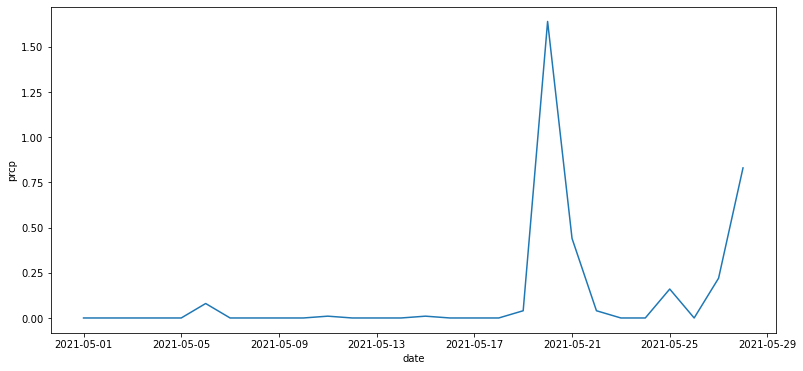

In [31]:
%matplotlib inline

plt.figure(figsize = (13,6))

sns.lineplot(x='date', y='prcp', data=reshaped_df)

plt.show()

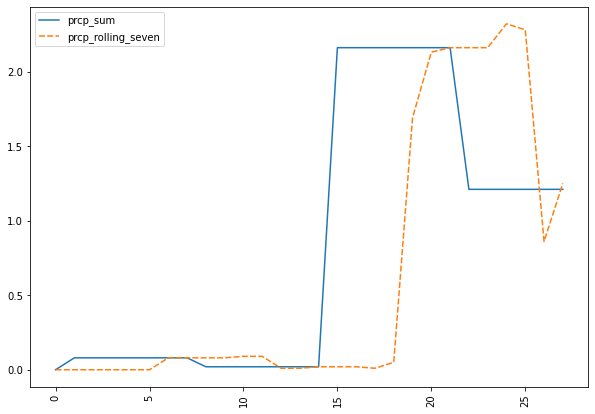

In [32]:
plt.figure(figsize = (10,7))

sns.lineplot(data=reshaped_df.iloc[:, 3:])
plt.xticks(rotation=90)
plt.show()